In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
import re
from src.functions import *
import random
import datetime

import absl.logging #prevent checkpoint warnings while training
absl.logging.set_verbosity(absl.logging.ERROR)

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
from keras import backend as K
from tensorflow.python.client import device_lib

reset_seed()

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print("\n\n devices: ",get_available_devices()) 


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Read data

### Load preprocessed dataset

In [7]:
from src.motion_refiner_4D import Motion_refiner

traj_n = 40
mr = Motion_refiner(load_models=True ,traj_n = traj_n)
feature_indices, obj_sim_indices, obj_poses_indices, traj_indices = mr.get_indices()
embedding_indices = np.concatenate([feature_indices,obj_sim_indices, obj_poses_indices])


dataset_name = "4D_10000_objs_2to6_norm_"
X,Y, data = mr.load_dataset(dataset_name, filter_data = True)
X_train, X_test, X_valid, y_train, y_test, y_valid, indices_train, indices_test, indices_val = mr.split_dataset(X, Y, test_size=0.2, val_size=0.1)


loading BERT model... 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


done
loading CLIP model... done
loading data... done
raw X: (10000, 952) 	Y: (10000, 160)
filtered X: (9896, 952) 	Y: (9896, 160)
X shape: (9896, 160)	 min: -0.300000 	 max 0.300000
Y shape: (9896, 160)	 min: -0.974066 	 max 0.979709
Train X: (6926, 952) 	Y: (6926, 160)
Test  X: (1980, 952) 	Y: (1980, 160)
Val   X: (990, 952) 	Y: (990, 160)


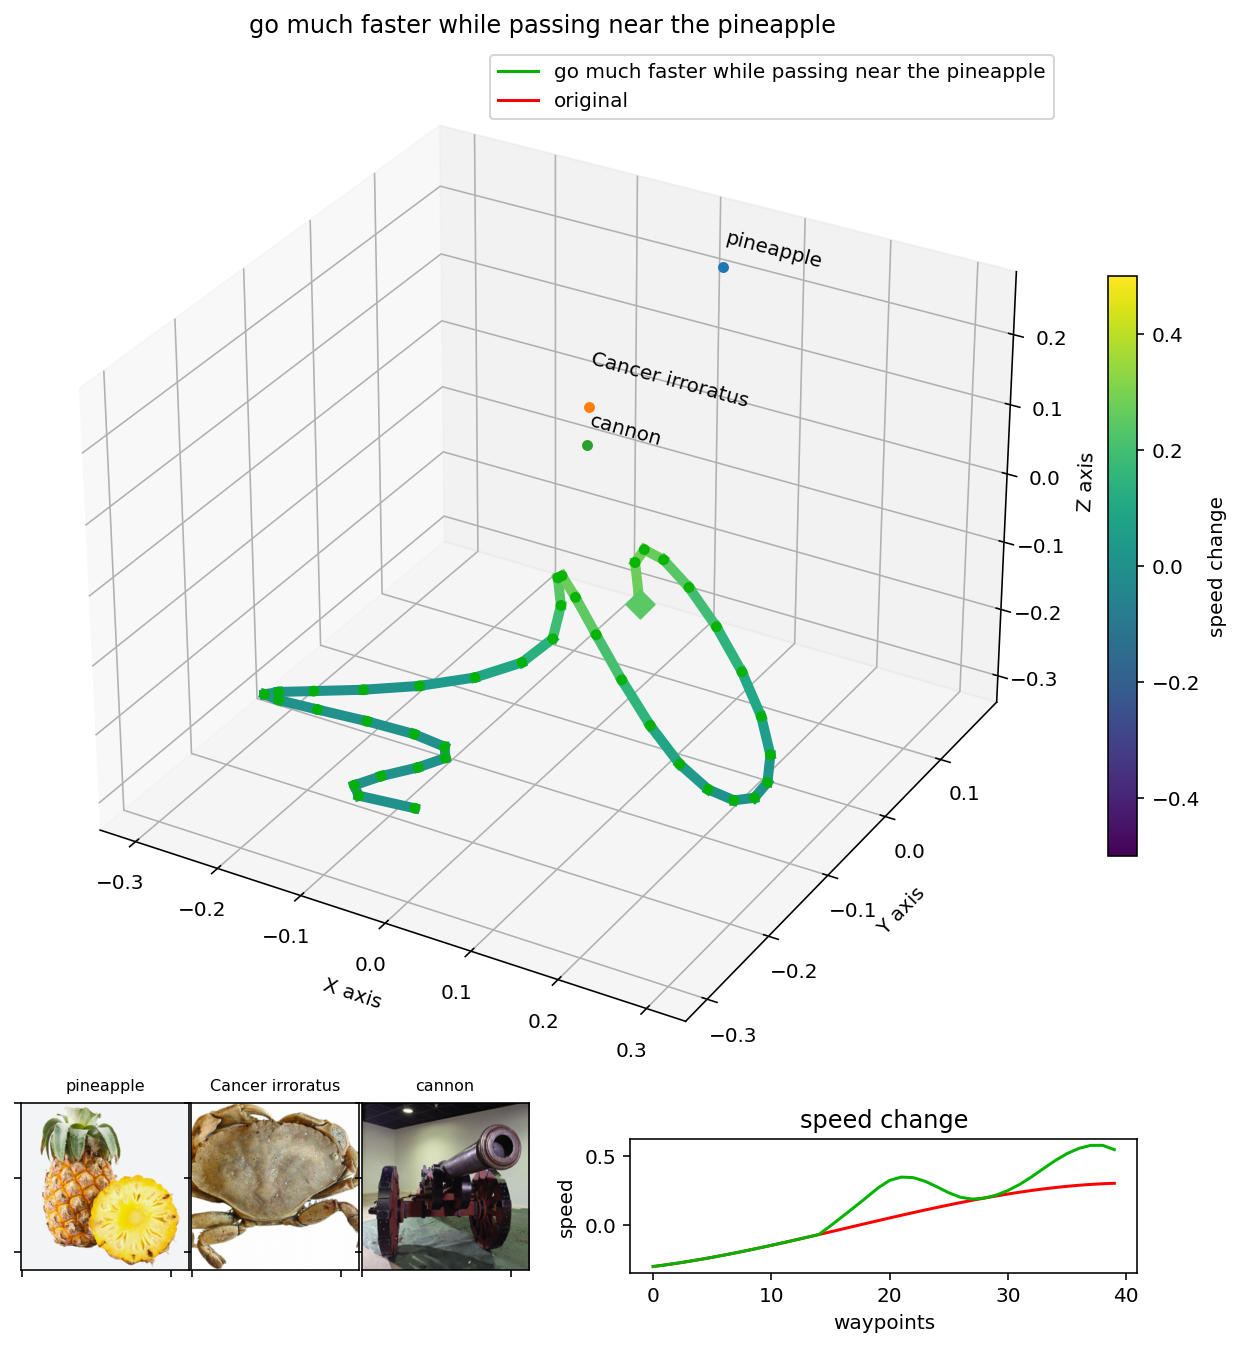

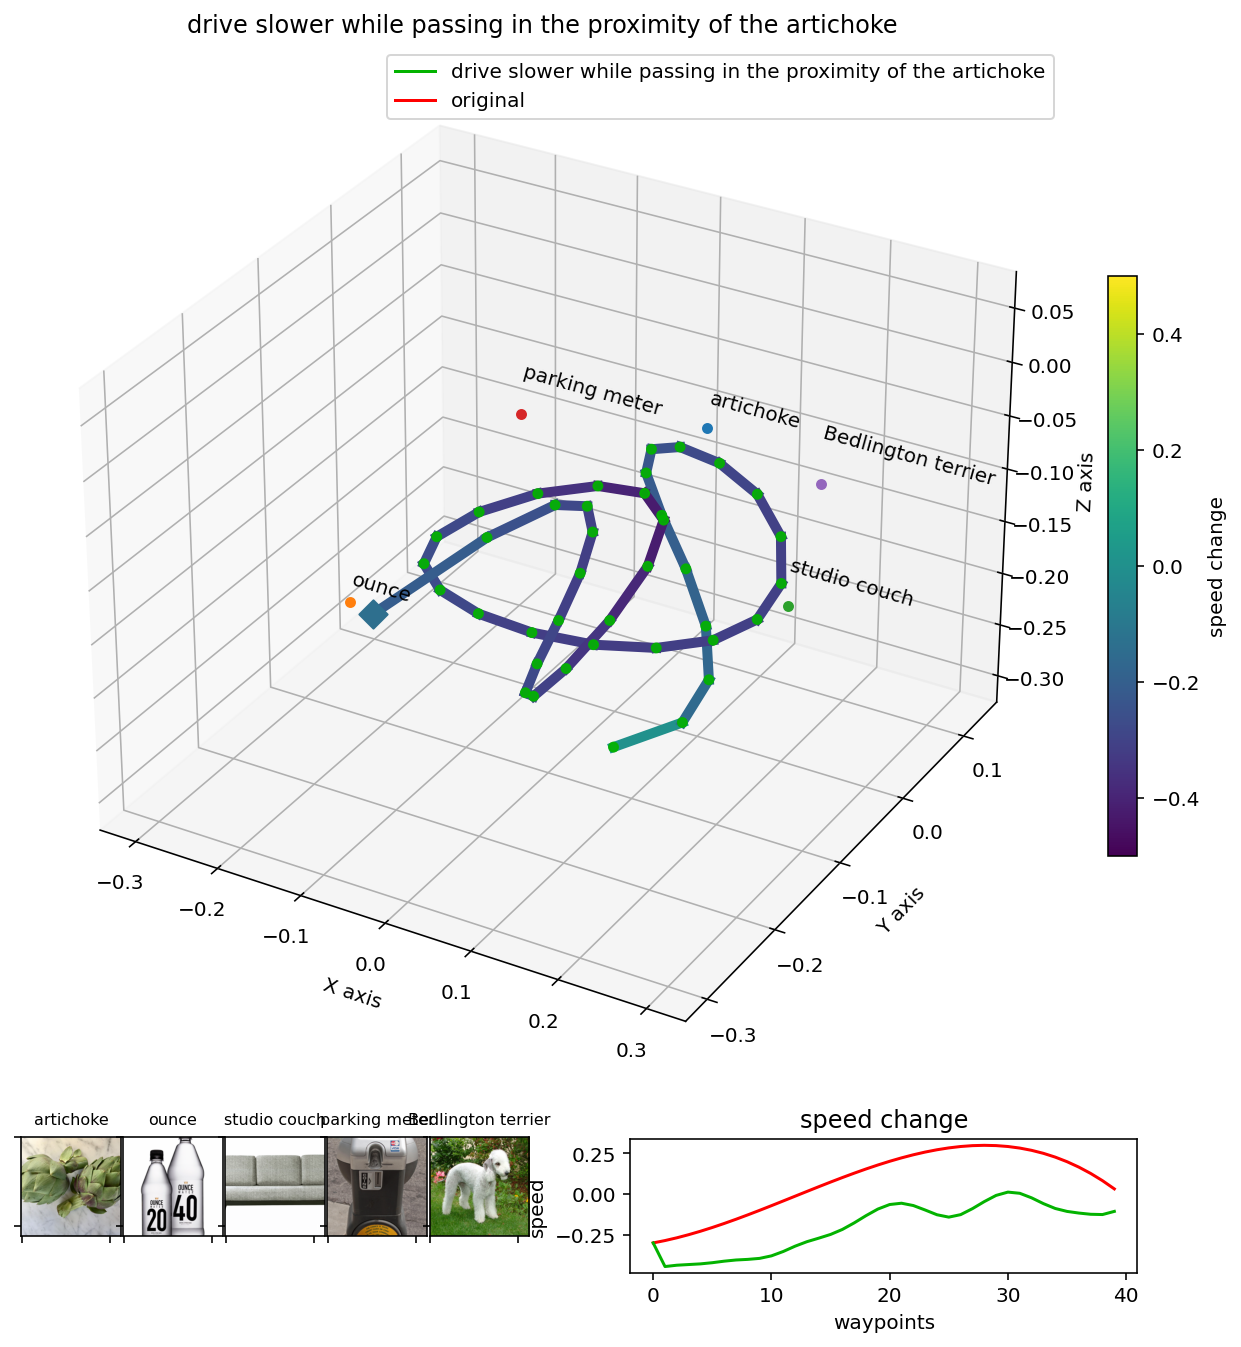

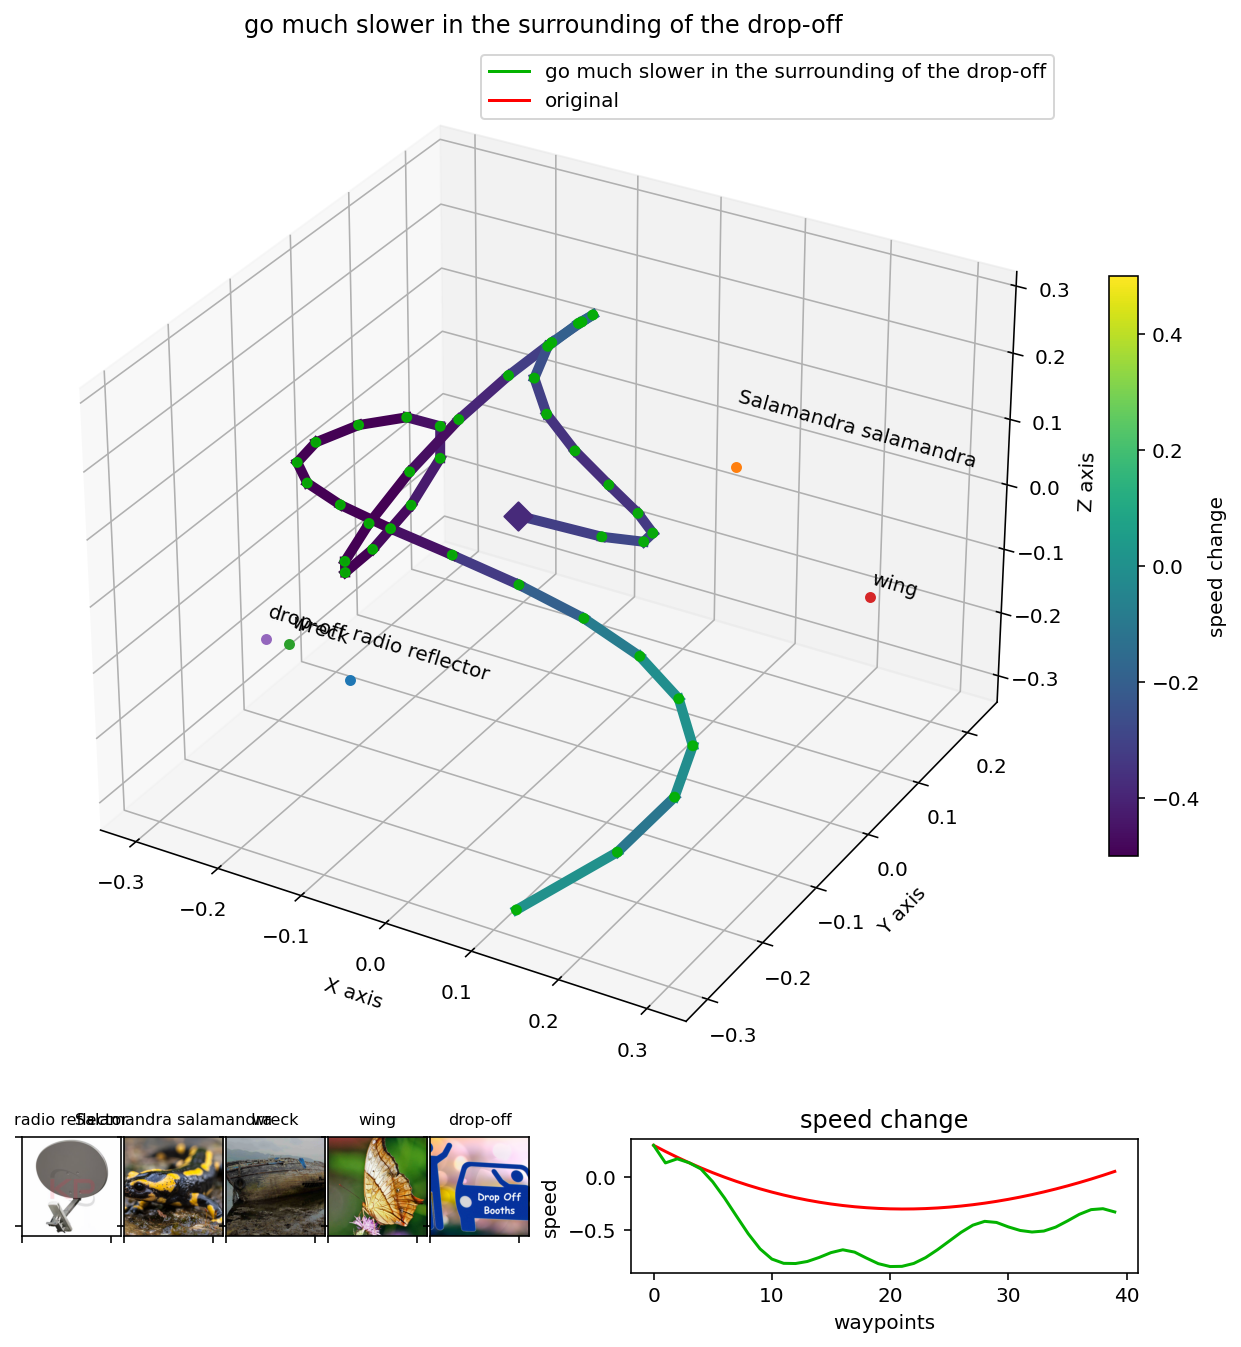

In [8]:
#dataset sample
from src.functions import *
data_sample = random.choices(data,k=3)
show_data4D(data_sample,image_loader=mr.image_loader)

In [9]:

#object matching accuracy
mr.evaluate_obj_matching(data)

acc:  0.9938598939436226


0.9938598939436226

# Model

In [10]:
from src.TF4D import *
model_path = "/home/mirmi/Arthur/trajnlp_ws/src/NL_trajectory_reshaper/models/experimet_20220604-173050/"
model_name =  "TF&num_layers_enc:2&num_layers_dec:4&d_model:256&dff:512&num_heads:8&dropout_rate:0.1&wp_d:4&bs:16&dense_n:512&num_dense:3&concat_emb:True&features_n:792&optimizer:adam&norm_layer:True&activation:linear.h5"
model_file = model_path+model_name
model = load_model(model_file)

{'num_layers_enc': 2, 'num_layers_dec': 4, 'd_model': 256, 'dff': 512, 'num_heads': 8, 'dropout_rate': 0.1, 'wp_d': 4, 'bs': 16, 'dense_n': 512, 'num_dense': 3, 'concat_emb': True, 'features_n': 792, 'optimizer': 'adam', 'norm_layer': True, 'activation': 'linear'}
loading weights:  /home/mirmi/Arthur/trajnlp_ws/src/NL_trajectory_reshaper/models/experimet_20220604-173050/TF&num_layers_enc:2&num_layers_dec:4&d_model:256&dff:512&num_heads:8&dropout_rate:0.1&wp_d:4&bs:16&dense_n:512&num_dense:3&concat_emb:True&features_n:792&optimizer:adam&norm_layer:True&activation:linear.h5


In [11]:
# tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [47]:
def prepare_x(x):
  objs = pad_array(list_to_wp_seq(x[:,obj_poses_indices],d=3),4,axis=-1) # no speed
  trajs = list_to_wp_seq(x[:,traj_indices],d=4)
  return np.concatenate([objs,trajs],axis = 1)

test_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_test),
                                                  list_to_wp_seq(y_test,d=4),
                                                  X_test[:,embedding_indices])).batch(X_test.shape[0])

x_test_new, y_test_new = prepare_x(X_test), list_to_wp_seq(y_test,d=4)
emb_test_new = X_test[:,embedding_indices]

# x_test_new, y_test_new, emb_test_new= increase_dataset(X_test ,y_test,embedding_indices,10)
result_eval = model.evaluate((x_test_new, y_test_new[:,:-1,:], emb_test_new), y_test_new[:,1:,:])[0]

g = generator(test_dataset,stop=True,augment=False)
x_t, y_t = next(g)
pred = generate(model ,x_t, traj_n=traj_n, start_index=6).numpy()
print(pred.shape)
result_gen = np.average((y_t - pred[:,1:,:])**2)

print("Test loss w generation: ",result_gen)


62/62 [==============================] - 1s 13ms/step - loss: 2.1412e-04 - mean_squared_error: 2.1398e-04
(1980, 40, 4)
Test loss w generation:  0.004041765660763302


In [48]:
%matplotlib qt
indices = np.random.choice(range(len(indices_test)), 6)
# pred_t = np.transpose(pred[:,:,:2],[0,2,1])

data_array = np.array(data)[indices_test[indices]]
show_data4D(data_array, pred=pred[indices],image_loader=mr.image_loader, color_traj=False)